# RNA Velocity of the Mouse Olfactory Epithelium using scVelo

### adapted from: https://github.com/basilkhuder/Seurat-to-RNA-Velocity
### authors: Alyx Gray, Chris Chua, and Matt Chang
### date: 03/08/2021

The loom file needed for this ipython script was created following our shell script described here: https://github.com/2020-bgmp/group-projects-yu-lab-project/blob/master/code/Velocyto/run10x.sh. The needed metadata can be found in the scVelo subdirectory in that repo: https://github.com/2020-bgmp/group-projects-yu-lab-project/tree/master/code/scVelo.

In [1]:
# Intialize
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib as plt
%load_ext rpy2.ipython

In [2]:
# Load AnnData object from loom file
loom = anndata.read_loom("FullCounts.loom")
sample_obs = pd.read_csv("cellID_obs.csv")
umap_cord = pd.read_csv("cell_embeddings.csv")
cell_clusters = pd.read_csv("clusters.csv")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
# # Create subset anndata object for Olfactory Sensory Neuron (OSN) clusters
# loom_sub = loom[loom.obs['Clusters'].isin([2, 3, 4, 5, 6, 7]),:].copy()
# loom_sub

In [4]:
# Grab the index information for the cell order
loom_index = pd.DataFrame(loom.obs.index)
loom_index = loom_index.rename(columns = {0:'Cell ID'})

import re

for i in loom_index['Cell ID']:
    x = re.search("(FullCounts:)(.*)(x)", i)
    x = x.group(2)
    x = x + "-1"
    
    loom_index['Cell ID'] = loom_index['Cell ID'].replace([i],x)
    
loom_index

,Cell ID
0,AAACGGGAGGGCACTA-1
1,AAAGTAGGTTCGTGAT-1
2,AAAGTAGAGTACACCT-1
3,AAACCTGCAGACAAGC-1
4,AAAGTAGGTGGCTCCA-1
...,...
9144,TTTGTCAAGGCGCTCT-1
9145,TTTGCGCAGCCAGTTT-1
9146,TTTGGTTGTGTCTGAT-1
9147,TTTGTCAAGTACATGA-1


In [5]:
# Grab UMAP coordinates for each cell
umap_cord = umap_cord.rename(columns = {'Unnamed: 0':'Cell ID'})
umap_cord

,Cell ID,UMAP_1,UMAP_2
0,AAACCTGAGCATGGCA-1,-16.609039,-2.002205
1,AAACCTGAGGACTGGT-1,10.173227,2.784285
2,AAACCTGAGTACGACG-1,2.677546,1.467091
3,AAACCTGCAAGTACCT-1,2.391503,2.089912
4,AAACCTGCAATCTACG-1,2.312333,3.810798
...,...,...,...
9144,TTTGTCATCCTTTACA-1,16.403944,-4.039779
9145,TTTGTCATCGCCAGCA-1,-0.172020,0.946359
9146,TTTGTCATCGCCGTGA-1,-6.923303,-0.252139
9147,TTTGTCATCTGGTTCC-1,-6.474628,9.321448


In [6]:
# Order UMAP coorinates using the indexes
umap_ordered = loom_index.merge(umap_cord, on = 'Cell ID')
umap_ordered = umap_ordered.iloc[:,1:]
umap_ordered

loom.obsm['X_umap'] = umap_ordered.values

In [7]:
# log-normalization, KNN, RNA velocity
scv.pp.filter_and_normalize(loom)
scv.pp.moments(loom)
scv.tl.velocity(loom, mode = "stochastic")
scv.tl.velocity_graph(loom)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:35) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:18) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:02:42) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:06:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [8]:
# add color information to cells
cell_colors = pd.read_csv("cell_colors.csv")
cell_colors = cell_colors.rename(columns = {'my_colors':'Cluster_colors'})
color_ordered = loom_index.merge(cell_colors, on = 'Cell ID')
color_ordered = color_ordered.iloc[:,3:]
loom.uns['Cluster_colors']=color_ordered
loom.uns['Cluster_colors']

,Cluster_colors
0,#00BB4E
1,#F8766D
2,#A3A500
3,#EA8331
4,#E76BF3
...,...
9144,#E76BF3
9145,#39B600
9146,#00C1A3
9147,#D89000


computing velocity embedding
    finished (0:00:09) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


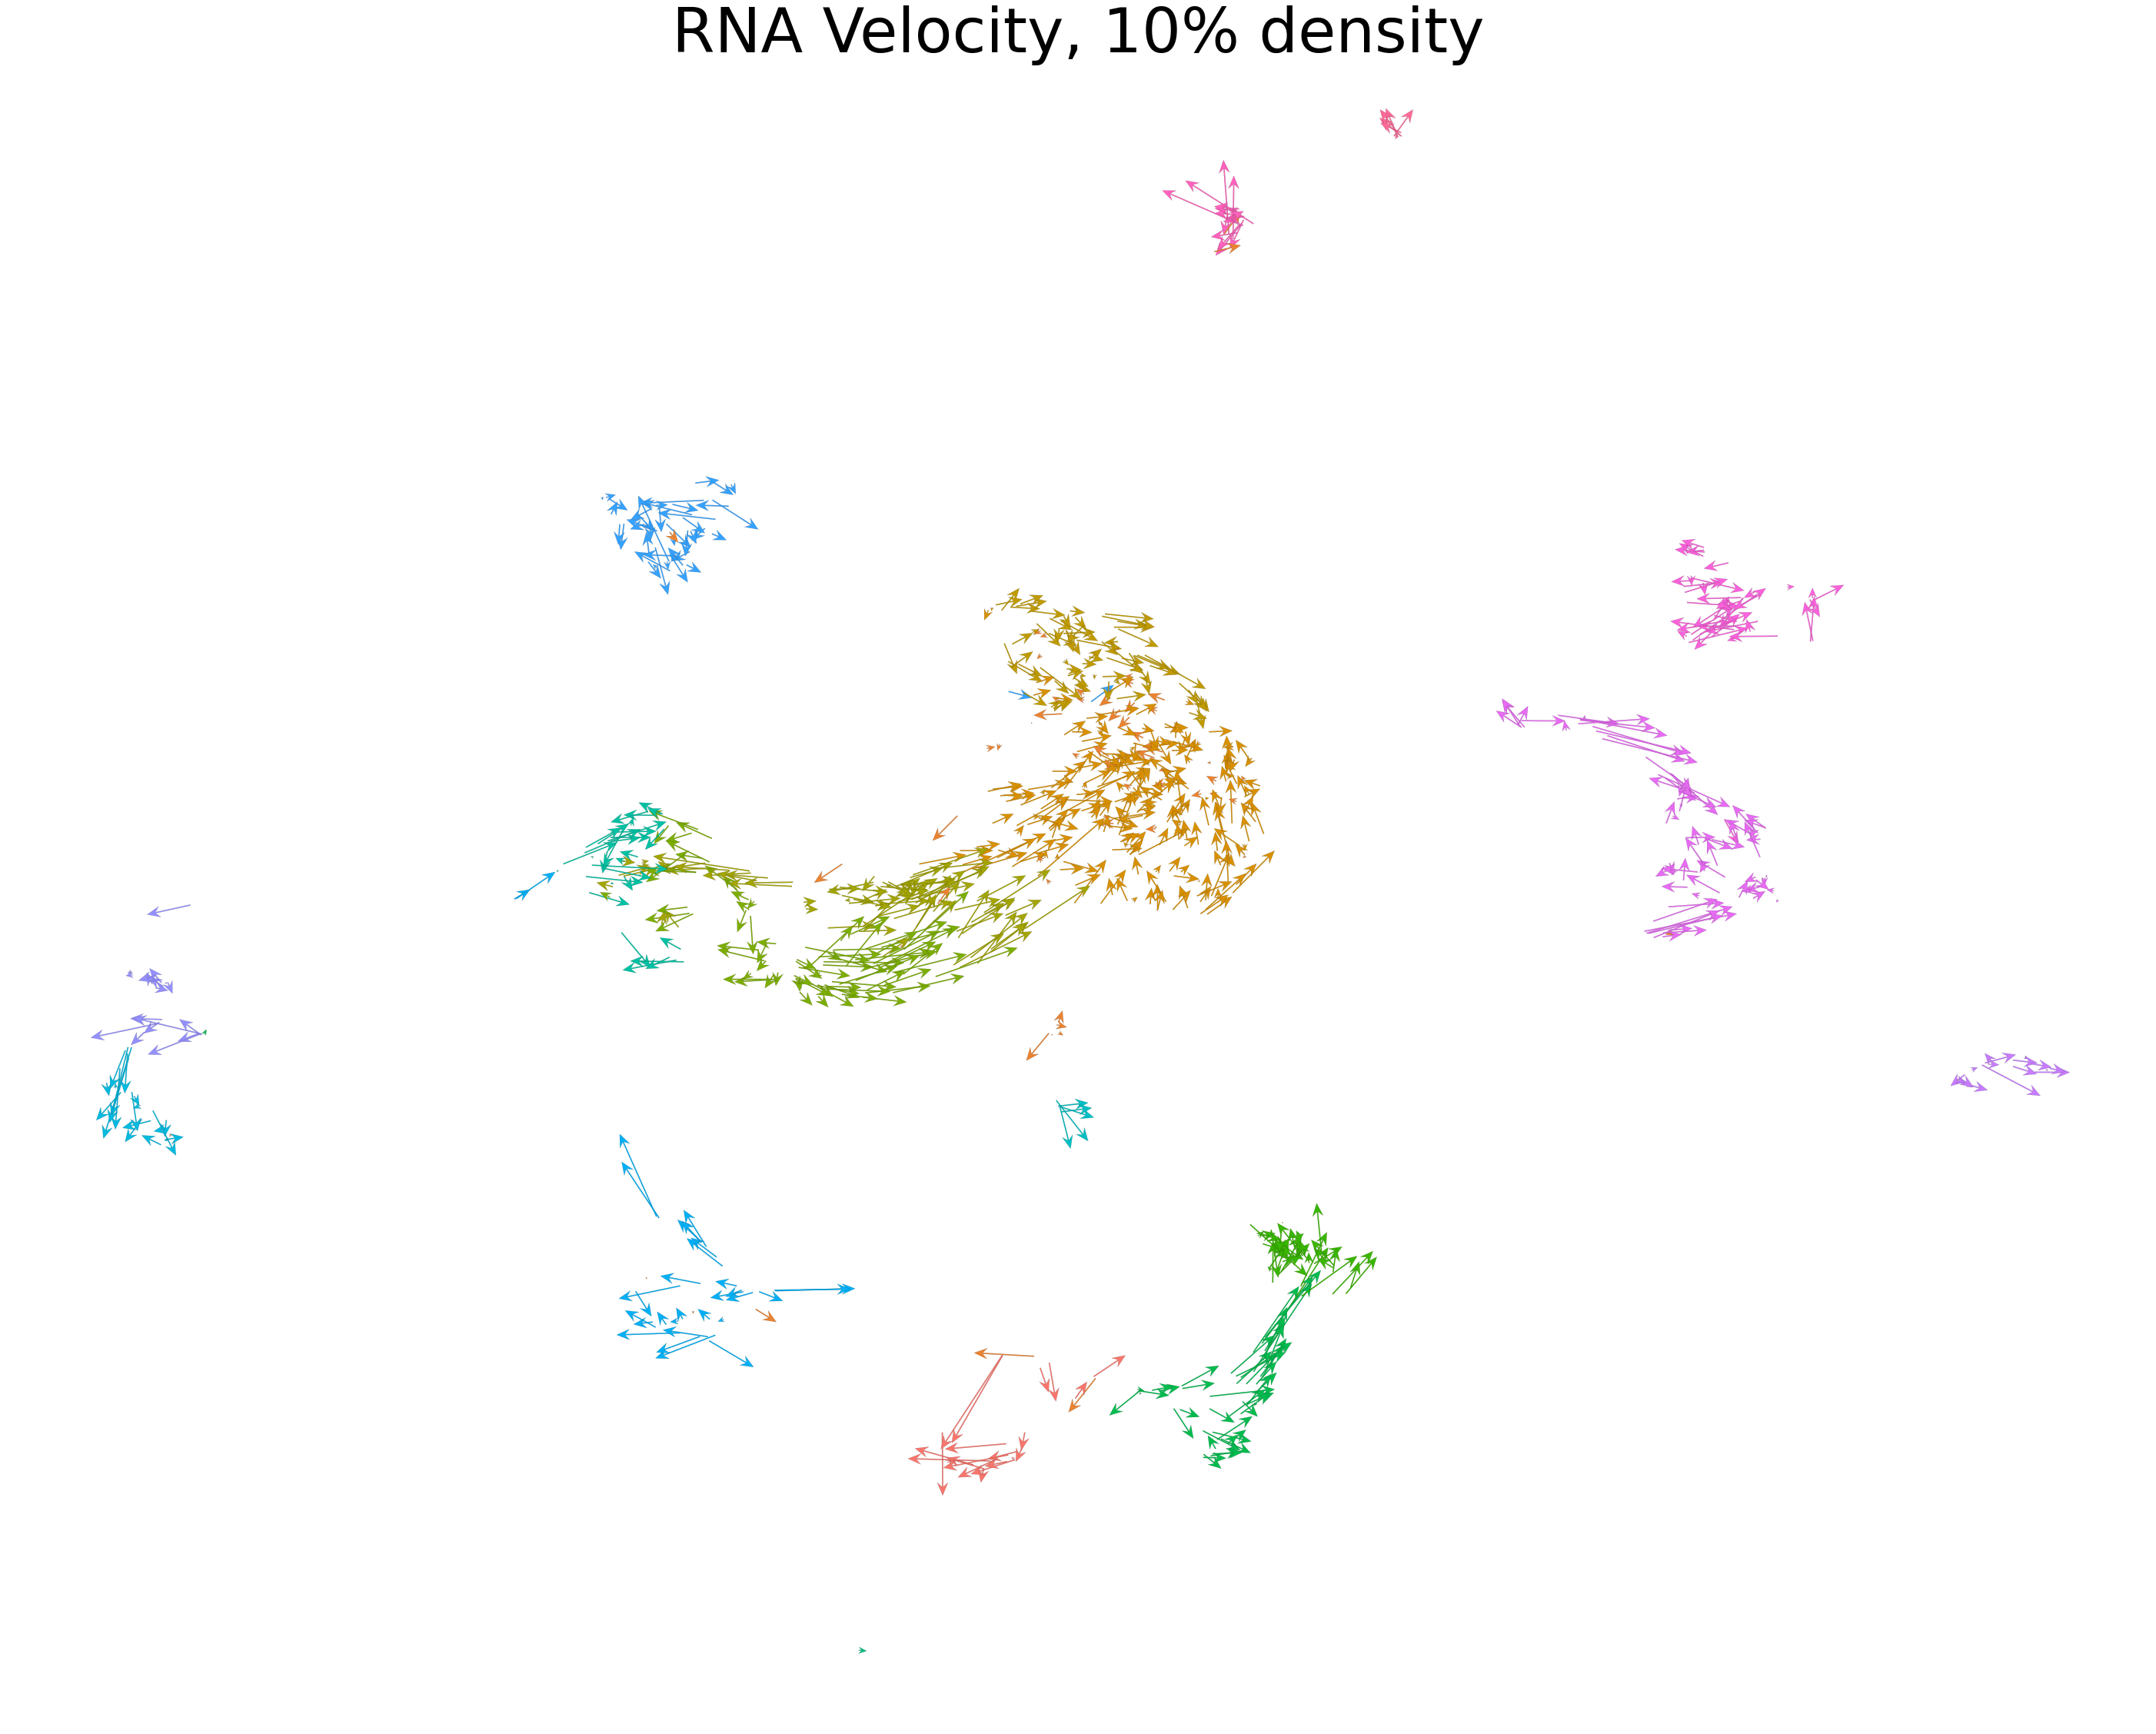

In [9]:
# Plot RNA Velocity in UMAP space
scv.pl.velocity_embedding(loom, basis = 'umap', 
                          figsize = (50,40), 
                          color=color_ordered, 
                          density=0.10, 
                          alpha=0, 
                          scale=1, 
                          arrow_length=15, 
                          colorbar=False, 
                          size=0, 
                          title="RNA Velocity, 10% density", 
                          fontsize=80,
                          smooth=True)

saving figure to file ./figures/scvelo_RNA_velocity_stream.svg


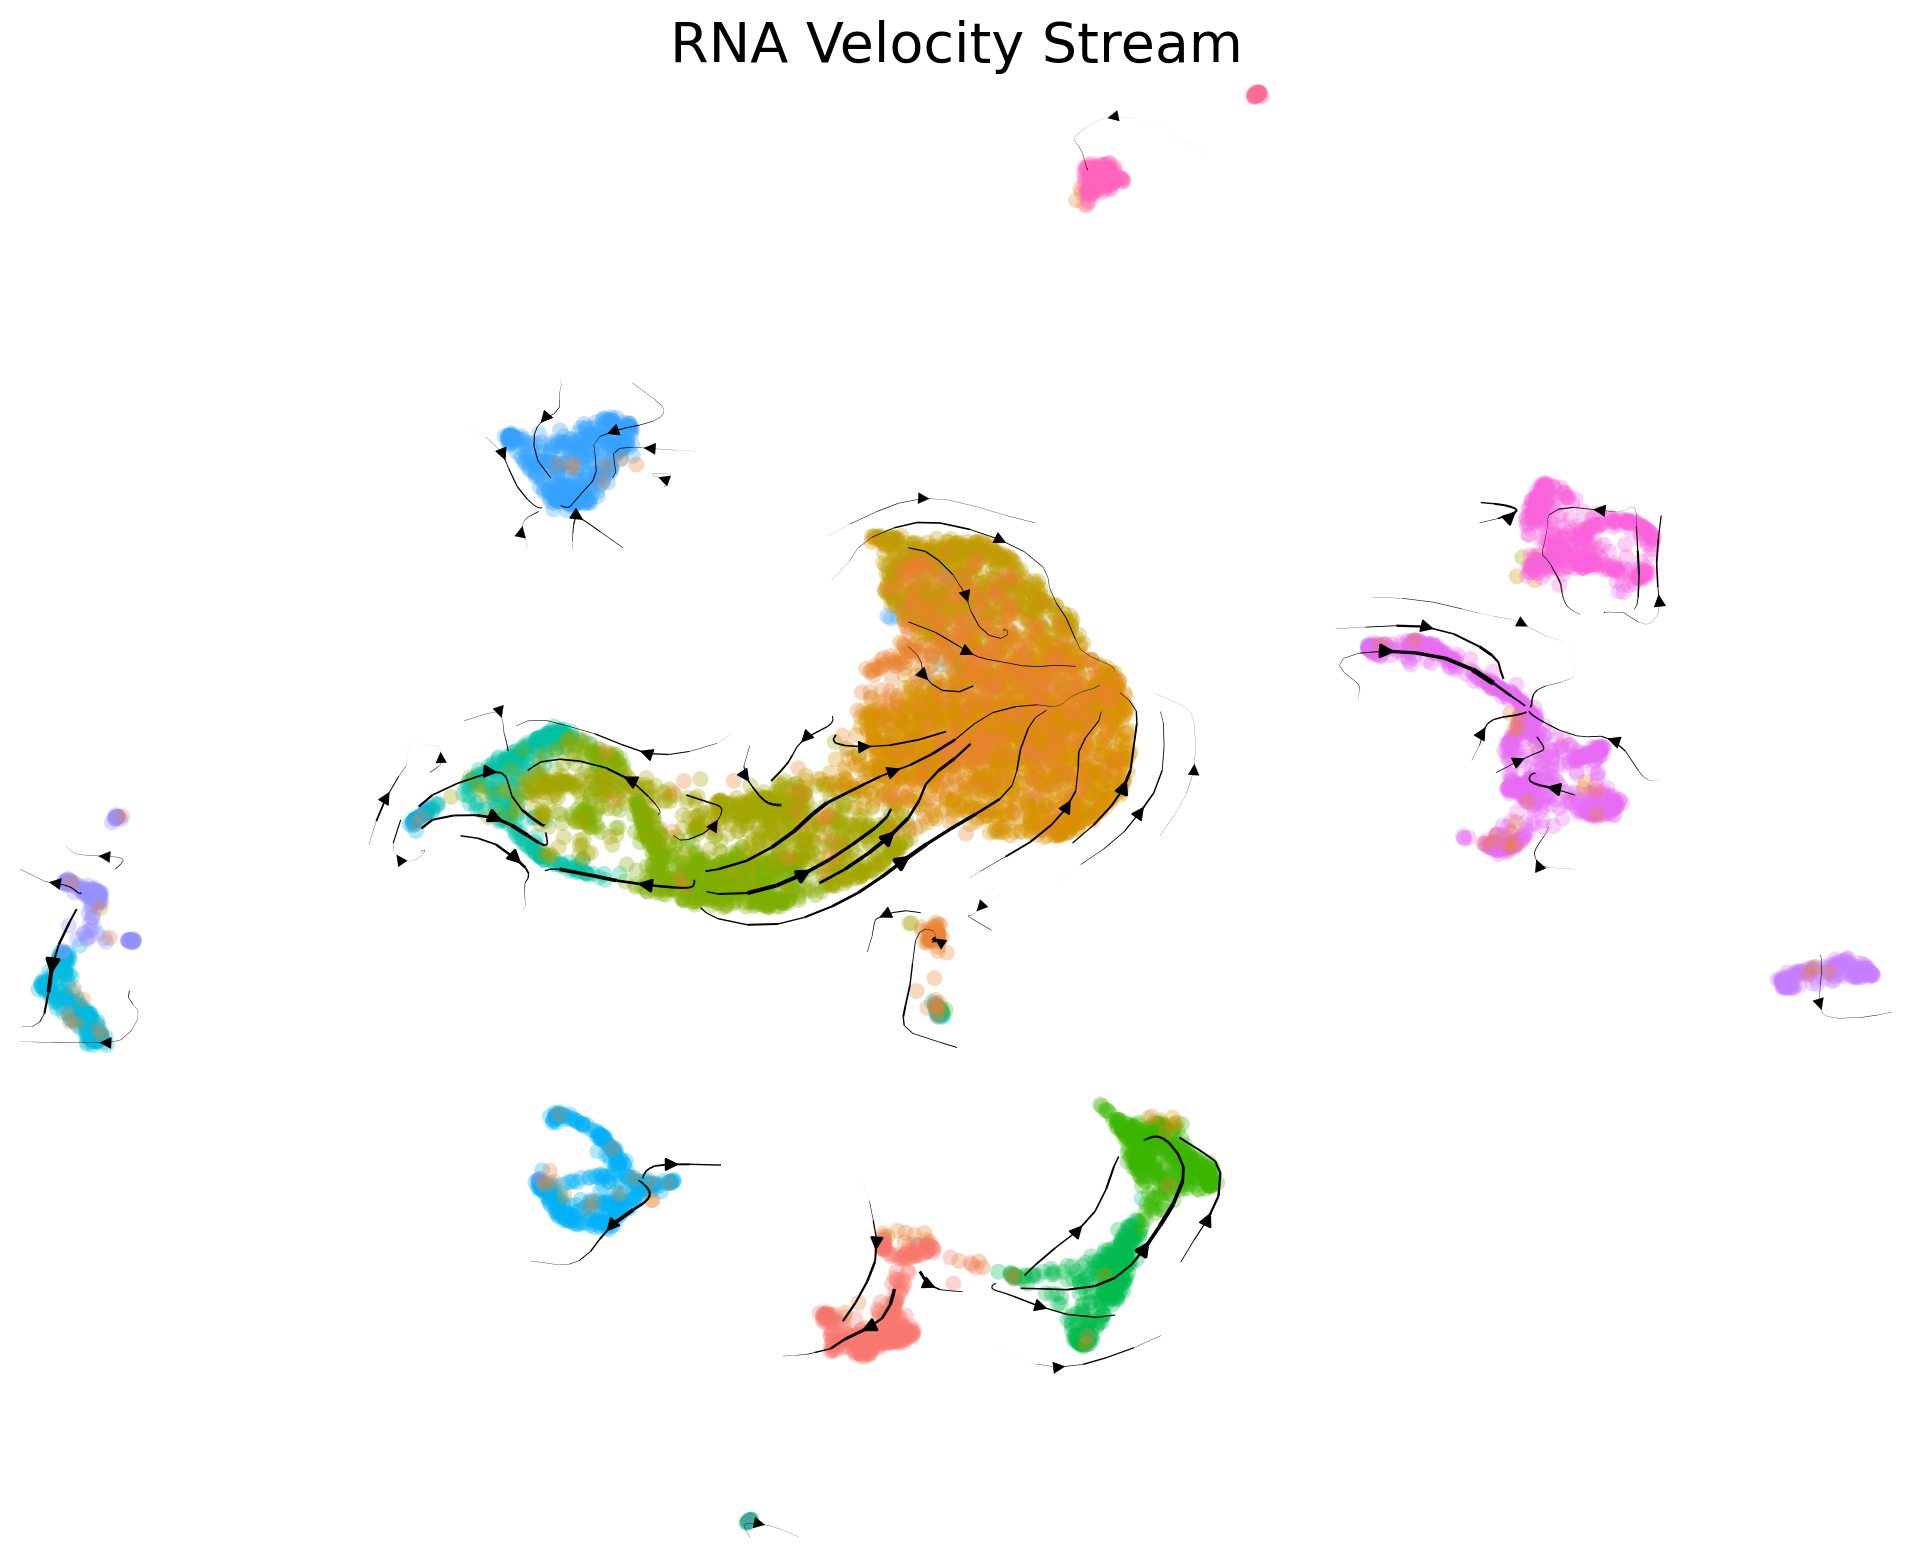

In [17]:
# Plot RNA Velocity Stream
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

scv.pl.velocity_embedding_stream(loom, basis='umap', 
                                 figsize = (50,40), 
                                 color=color_ordered, 
                                 min_mass=0, 
                                 n_neighbors=2, 
                                 title="RNA Velocity Stream", 
                                 fontsize=20,
                                 colorbar=False, 
                                 save = 'RNA_velocity_stream.svg')

In [11]:
# # Indexes for OSN subset
# loom_sub_index = pd.DataFrame(loom_sub.obs.index)
# loom_sub_index = loom_sub_index.rename(columns = {0:'Cell ID'})

# import re

# for i in loom_sub_index['Cell ID']:
#     x = re.search("(FullCounts:)(.*)(x)", i)
#     x = x.group(2)
#     x = x + "-1"
    
#     loom_sub_index['Cell ID'] = loom_sub_index['Cell ID'].replace([i],x)
    
# loom_sub_index

In [12]:
# # Ordered UMAP coordinates for OSN subset
# umap_sub_ordered = loom_sub_index.merge(umap_cord, on = 'Cell ID')
# umap_sub_ordered = umap_sub_ordered.iloc[:,1:]
# umap_sub_ordered

# loom_sub.obsm['X_umap'] = umap_sub_ordered.values

In [13]:
# # log-normalization, KNN, RNA velocity for OSN subset
# scv.pp.filter_and_normalize(loom_sub, enforce=True)
# scv.pp.neighbors(loom_sub) # recompute neighbor graph
# scv.pp.moments(loom_sub)
# scv.tl.velocity(loom_sub, mode = "stochastic")
# scv.tl.velocity_graph(loom_sub)

In [14]:
# # Color information for OSN subset
# color_sub_ordered = loom_sub_index.merge(cell_colors, on = 'Cell ID')
# color_sub_ordered = color_sub_ordered.iloc[:,3:]
# loom_sub.uns['Cluster_colors']=color_sub_ordered
# loom_sub.uns['Cluster_colors']

In [15]:
# # RNA Velocity Stream Plot for OSN subset
# scv.pl.velocity_embedding_stream(loom_sub, basis='umap', 
#                                  figsize = (50,40), 
#                                  color=color_sub_ordered, 
#                                  min_mass=0, 
#                                  n_neighbors=2, 
#                                  title="RNA Velocity Stream", 
#                                  fontsize=20,
#                                  colorbar=False,
#                                  projection="3d")